In [1]:
# %pip install numpy
# %pip install -U scikit-learn imbalanced-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install pylatexenc
# %pip install opencv-python
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install joblib
# %pip install pandas
# %pip install seaborn
# %pip install imblearn

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from monai.transforms import ScaleIntensity
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_machine_learning.algorithms import PegasosQSVC
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute

from qiskit_machine_learning.utils import algorithm_globals
algorithm_globals.random_seed = 12345

import warnings
warnings.filterwarnings('ignore')

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths

In [4]:
train_path_norm = f'{path}/chest_xray/chest_xray/train/NORMAL'
train_path_pneu = f'{path}/chest_xray/chest_xray/train/PNEUMONIA'
test_path_norm = f'{path}/chest_xray/chest_xray/test/NORMAL'
test_path_pneu = f'{path}/chest_xray/chest_xray/test/PNEUMONIA'

#### Count files in directory

In [5]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))])

print("Length train_path_norm:", count_images(train_path_norm))
print("Length train_path_pneu:", count_images(train_path_pneu))
print("Length test_path_norm:", count_images(test_path_norm))
print("Length test_path_pneu:", count_images(test_path_pneu))

Length train_path_norm: 1341
Length train_path_pneu: 3875
Length test_path_norm: 234
Length test_path_pneu: 390


#### Check data

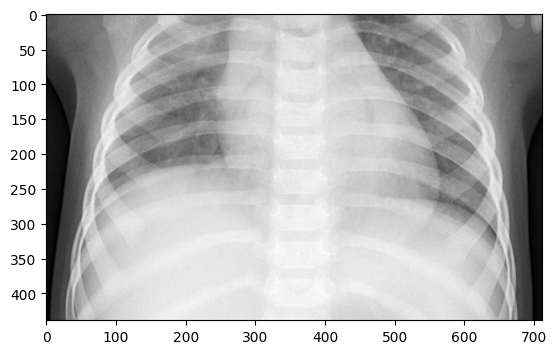

In [6]:
xray_image = cv2.imread(f'{train_path_pneu}/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

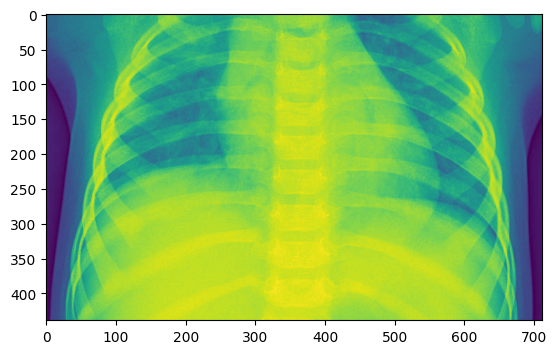

In [7]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Load and preprocess the images

In [8]:
img_size = (256, 256)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and flattens them into numpy arrays.

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img).flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=(256, 256)):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Display images for train

Found 5216 validated image filenames belonging to 2 classes.


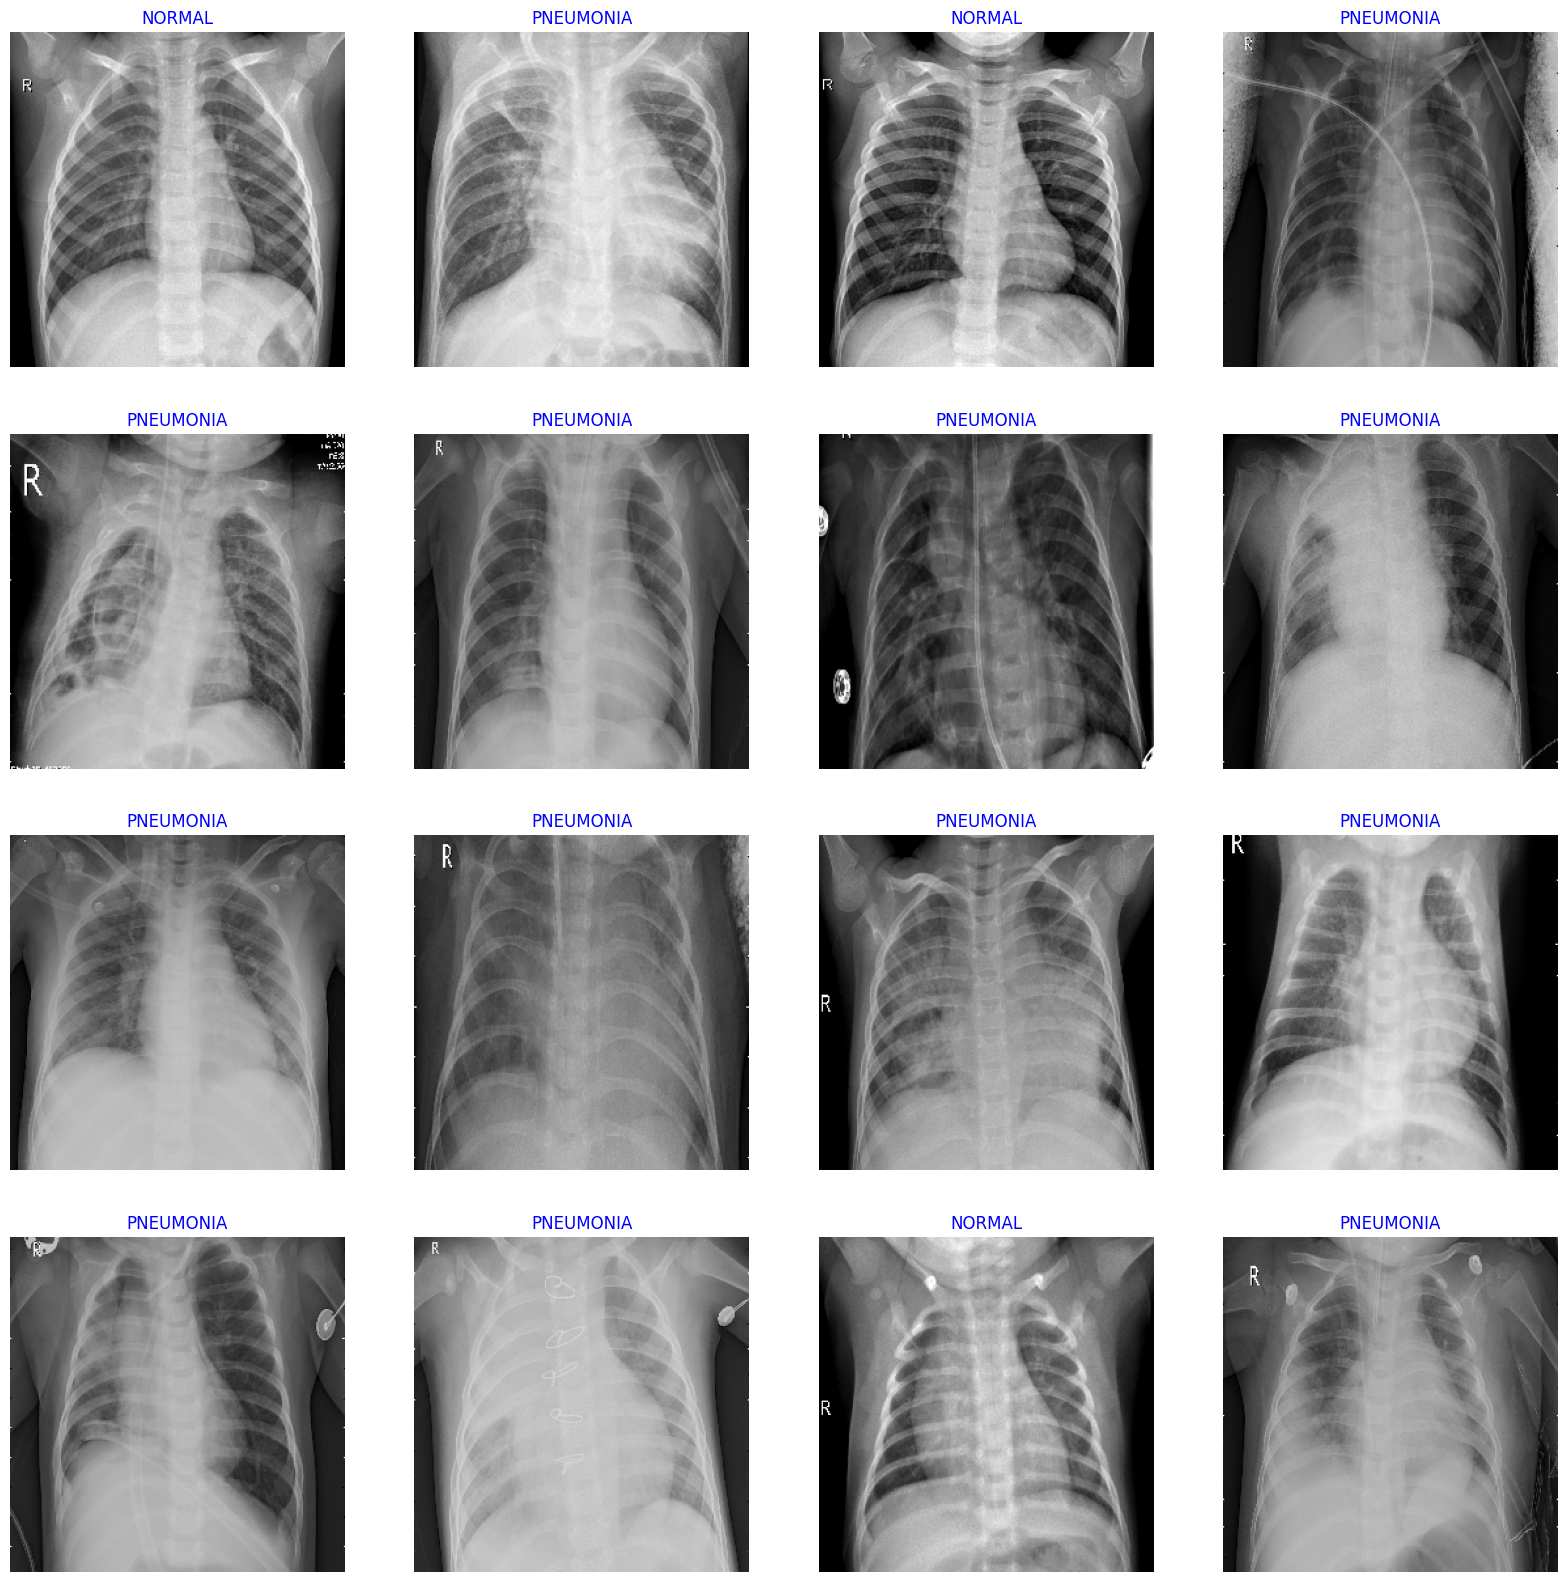

In [9]:
def create_dataframe_from_directory(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

df_norm = create_dataframe_from_directory(train_path_norm, 'NORMAL')
df_pneu = create_dataframe_from_directory(train_path_pneu, 'PNEUMONIA')

train_df = pd.concat([df_norm, df_pneu], ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)

def scalar(img):
    return img

batch_size = 32
tr_gen = ImageDataGenerator(preprocessing_function= scalar)


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#### Prepare & preprocess data

In [10]:
train_data_norm, train_labels_norm = load_and_limit_data(train_path_norm, 0, 1300, target_size=img_size)
train_data_pneu, train_labels_pneu = load_and_limit_data(train_path_pneu, 1, 1500, target_size=img_size)
X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

test_data_norm, test_labels_norm = load_and_limit_data(test_path_norm, 0, 234, target_size=img_size)
test_data_pneu, test_labels_pneu = load_and_limit_data(test_path_pneu, 1, 390, target_size=img_size)
X_test = np.asarray(test_data_norm + test_data_pneu)
y_test = np.asarray(test_labels_norm + test_labels_pneu)

#### Reduce to n Dimensions

In [11]:
def reduce_to_n_dimensions(data, n_dimensions):
    """
    Reduces the number of features in the dataset to n dimensions by averaging subsets of features.
    
    Args:
        data (np.ndarray): Input dataset of shape (n_samples, n_features).
        n_dimensions (int): Target number of dimensions.
    
    Returns:
        np.ndarray: Reduced dataset of shape (n_samples, n_dimensions).
    """
    n_features = data.shape[1]
    if n_dimensions > n_features:
        raise ValueError("Target dimensions cannot be greater than the number of features in the dataset.")
    
    # Split features into n_dimensions equal parts
    split_size = n_features // n_dimensions
    reduced_data = np.zeros((data.shape[0], n_dimensions))
    
    for i in range(n_dimensions):
        start_idx = i * split_size
        end_idx = start_idx + split_size if i < n_dimensions - 1 else n_features
        reduced_data[:, i] = np.mean(data[:, start_idx:end_idx], axis=1)
    
    return reduced_data

In [12]:
n_dimensions = 18
X_train_red = reduce_to_n_dimensions(X_train, n_dimensions)
X_test_red = reduce_to_n_dimensions(X_test, n_dimensions)

In [13]:
X_train_reduced = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X_train_red)
X_test_reduced = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X_test_red)

#### Convolutional Layer

In [14]:
def conv_layer(num_qubits, label, params):
    """
    Create a convolutional layer.
    Applies RX gates to each qubit.
    """
    qc = QuantumCircuit(num_qubits, name=label)
    for i in range(num_qubits):
        qc.rx(params[i], i)
    return qc

#### Pooling Layer

In [15]:
def pool_layer(qubits, label):
    """
    Create a pooling layer.
    Applies CX gates between adjacent qubits.
    """
    qc = QuantumCircuit(len(qubits), name=label)
    for i in range(0, len(qubits) - 1, 2):
        qc.cx(qubits[i], qubits[i + 1])
    return qc

#### Display the categorized file paths and labels

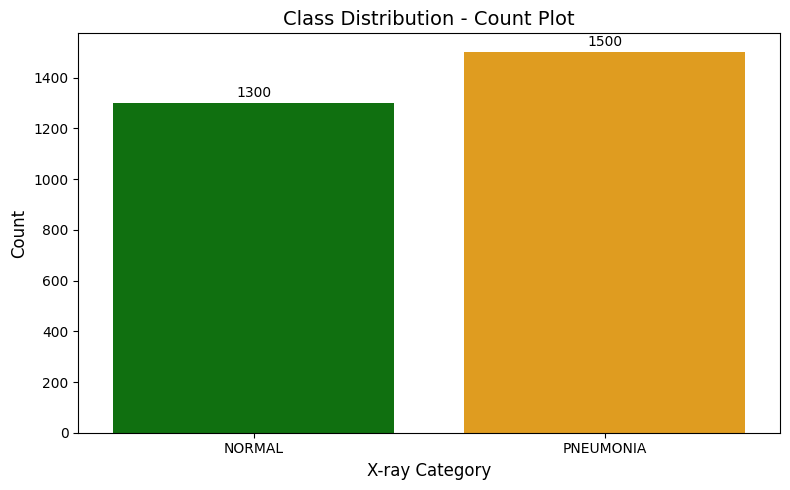

In [16]:
labels = train_labels_norm + train_labels_pneu

df = pd.DataFrame({'label': ['NORMAL' if lbl == 0 else 'PNEUMONIA' for lbl in labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='label', 
    hue='label',
    palette={'NORMAL': 'green', 'PNEUMONIA': 'orange'},
    dodge=False,
    legend=False
)

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('X-ray Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Plot the data

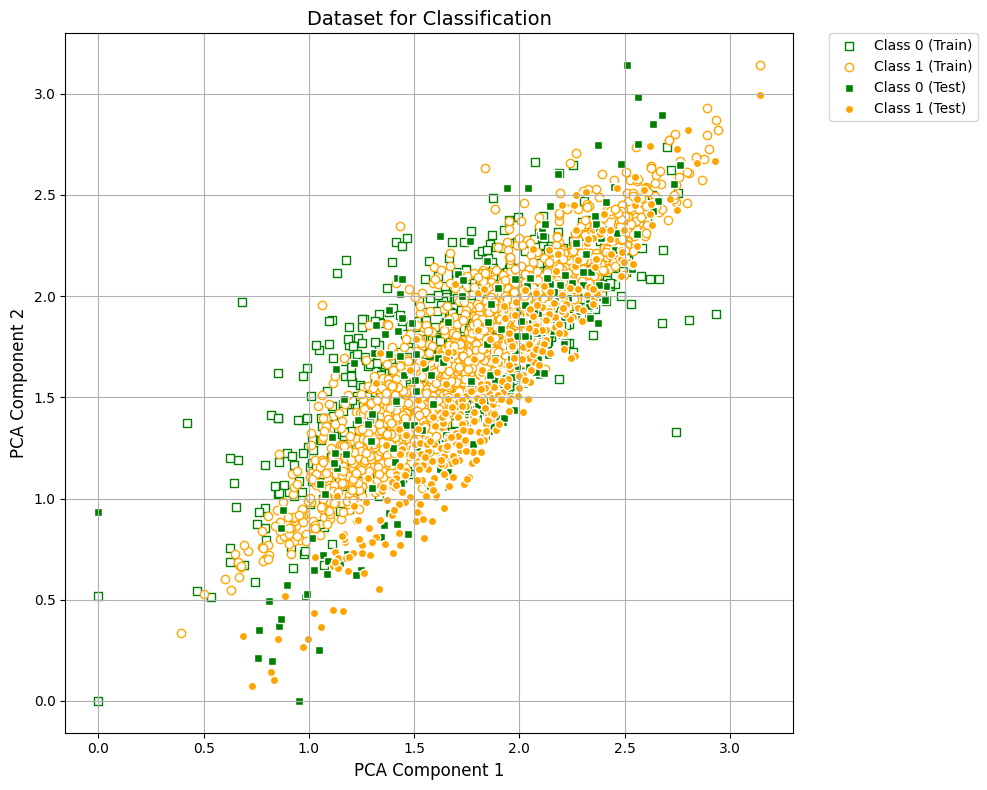

In [17]:
plt.figure(figsize=(10, 8))

plt.scatter(
    X_train_reduced[(y_train == 0), 0],
    X_train_reduced[(y_train == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="green",
    label="Class 0 (Train)",
)

plt.scatter(
    X_train_reduced[(y_train == 1), 0],
    X_train_reduced[(y_train == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="orange",
    label="Class 1 (Train)",
)

plt.scatter(
    X_test_reduced[y_test == 0, 0],
    X_test_reduced[y_test == 0, 1],
    marker="s",
    facecolors="green",
    edgecolors="w",
    label="Class 0 (Test)",
)

plt.scatter(
    X_test_reduced[y_test == 1, 0],
    X_test_reduced[y_test == 1, 1],
    marker="o",
    facecolors="orange",
    edgecolors="w",
    label="Class 1 (Test)",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Dataset for Classification", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Build ansatz

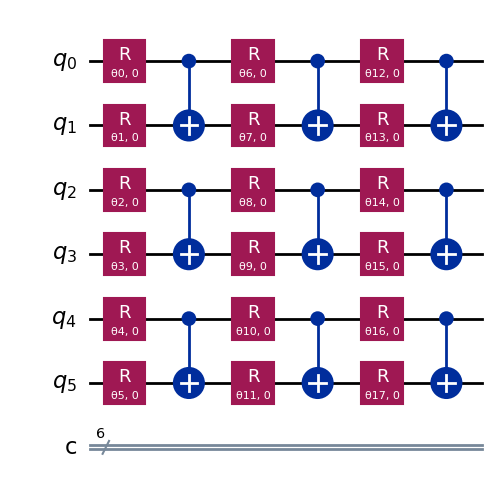

In [18]:

def build_ansatz(num_qubits, params):
    """
    Builds the ansatz ensuring equal layers across all qubits.
    """
    ansatz = QuantumCircuit(num_qubits, name="Ansatz")
    layer_params = iter(params)

    for layer in range(1, 4):
        conv_params = [next(layer_params) for _ in range(num_qubits)]
        ansatz.compose(
            conv_layer(num_qubits, f"c{layer}", conv_params),
            range(num_qubits),
            inplace=True
        )

        ansatz.compose(
            pool_layer(range(num_qubits), f"p{layer}"),
            range(num_qubits),
            inplace=True
        )
    
    return ansatz

def calculate_total_params(num_qubits, layers=3):
    """
    Calculate the total number of parameters required for the ansatz.
    """
    total_params = num_qubits * layers
    return total_params


num_qubits = 6
total_params = calculate_total_params(num_qubits)
params = [Parameter(f'θ{i}') for i in range(total_params)]


ansatz = build_ansatz(num_qubits, params)
circuit = QuantumCircuit(num_qubits, num_qubits)
circuit.compose(ansatz, range(num_qubits), inplace=True)
circuit = circuit.decompose()

circuit.draw("mpl", style="iqx")


#### Quantum Kernel Setup

In [19]:
sampler = Sampler()

tau = 100
C = 1000

fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=circuit)

#### Fit model

In [20]:
pegasos_svc = PegasosQSVC(quantum_kernel=kernel, C=C, num_steps=tau)

pegasos_svc.fit(X_train_reduced, y_train)

pegasos_score = pegasos_svc.score(X_test_reduced, y_test)
print(f"PegasosQSVC classification test score: {pegasos_score}")

PegasosQSVC classification test score: 0.6522435897435898


#### Save model

In [21]:
pegasos_svc.save('models/Upgraded_PegasosQSVC_Fidelity_quantm_trainer_pneumonia.model')

In [22]:
y_pred = pegasos_svc.predict(X_test_reduced)

In [23]:
pegasos = pegasos_svc.predict(X_test_reduced)

print("\nPegasos Kernel Classification Report:")
print(metrics.classification_report(y_test, pegasos))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, pegasos))


Pegasos Kernel Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.21      0.31       234
           1       0.66      0.92      0.77       390

    accuracy                           0.65       624
   macro avg       0.64      0.56      0.54       624
weighted avg       0.64      0.65      0.60       624

Confusion Matrix:
[[ 48 186]
 [ 30 360]]


In [24]:
classification_rep = metrics.classification_report(y_test, y_pred, output_dict=True, zero_division=True)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, pegasos_svc.decision_function(X_test_reduced))

print("Classification Report:", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report: {'0': {'precision': 0.625, 'recall': 0.21367521367521367, 'f1-score': 0.3184713375796178, 'support': 234.0}, '1': {'precision': 0.6617647058823529, 'recall': 0.9230769230769231, 'f1-score': 0.7708779443254818, 'support': 390.0}, 'accuracy': 0.657051282051282, 'macro avg': {'precision': 0.6433823529411764, 'recall': 0.5683760683760684, 'f1-score': 0.5446746409525498, 'support': 624.0}, 'weighted avg': {'precision': 0.6479779411764706, 'recall': 0.657051282051282, 'f1-score': 0.6012254667957828, 'support': 624.0}}
Confusion Matrix:
 [[ 50 184]
 [ 30 360]]
ROC AUC Score: 0.3320458031996493


#### Predicted probability for Positive Class

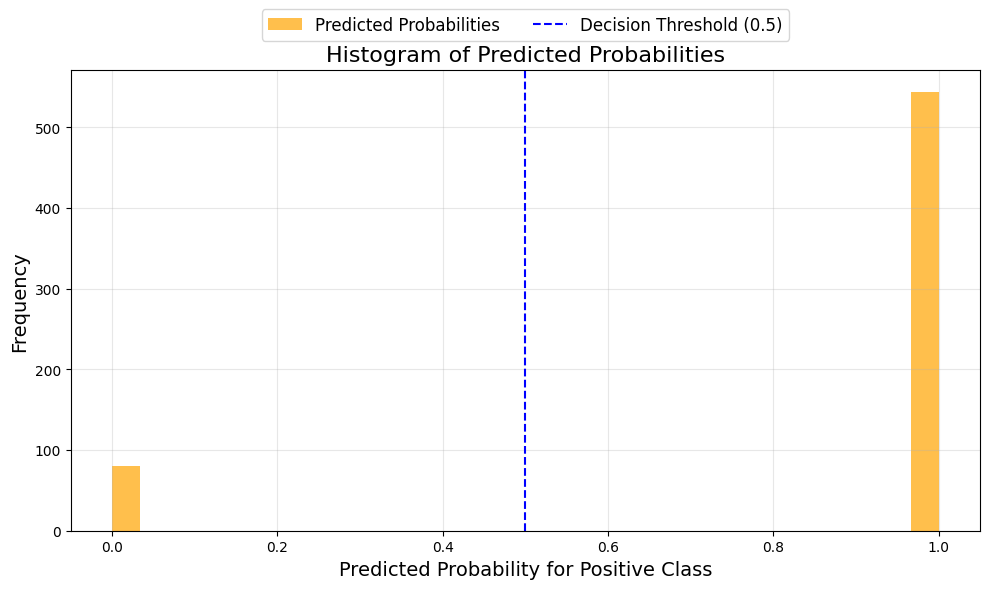

In [25]:
y_pred_probabilities_tensor = torch.tensor(y_pred, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

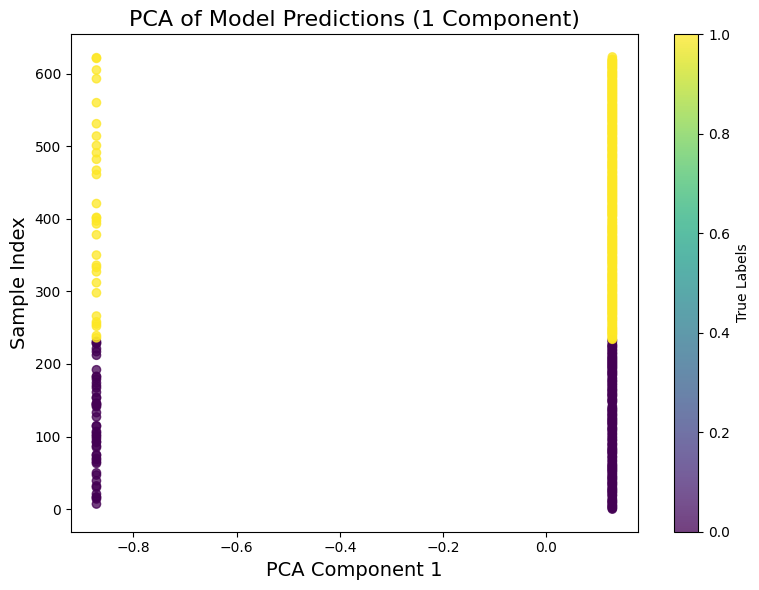

In [26]:
if y_pred.ndim == 1:
    labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))

plt.scatter(features_pca, range(len(features_pca)), c=y_test, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

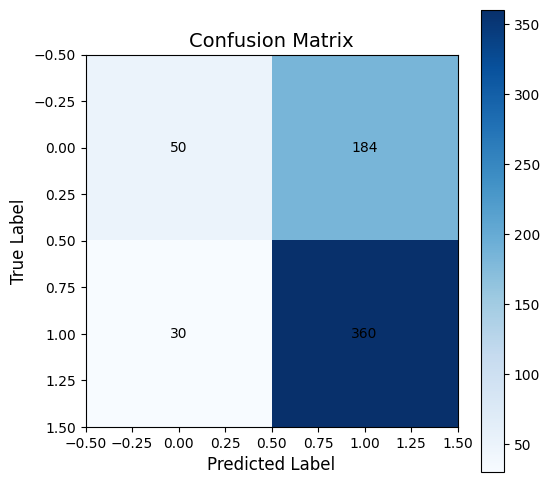

In [27]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()

#### Plot the ROC curve

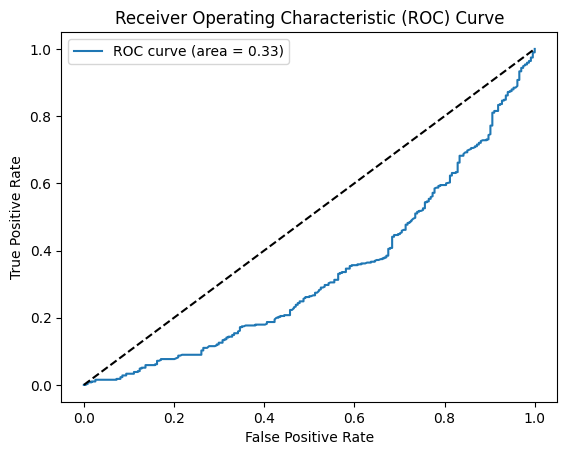

In [28]:
decision_function = pegasos_svc.decision_function(X_test_reduced)

fpr, tpr, _ = metrics.roc_curve(y_test, decision_function)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")

plt.show()

#### Load model

In [29]:
loaded_model = PegasosQSVC.load('models/Upgraded_PegasosQSVC_Fidelity_quantm_trainer_pneumonia.model')

In [30]:
train_score = loaded_model.score(X_train_reduced[:10], y_train[:10])
test_score = loaded_model.score(X_test_reduced[:10], y_test[:10])

print(f"Quantum QSVC on the training dataset: {train_score:.2f}")
print(f"Quantum QSVC on the test dataset: {test_score:.2f}")

Quantum QSVC on the training dataset: 0.70
Quantum QSVC on the test dataset: 0.10


#### Test loaded model

In [31]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright